Silhouette Score (GMM on PCA data): 0.7770639330208756

Cluster Mean Global Scores:
 cluster
2    1.005418
0   -0.104565
1   -0.885050
Name: global, dtype: float64

Sample Data with Assigned Groups:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.496714  -0.138264   0.647689   1.523030  -0.234153  -0.234137   
1  -0.463418  -0.465730   0.241962  -1.913280  -1.724918  -0.562288   
2   1.465649  -0.225776   0.067528  -1.424748  -0.544383   0.110923   
3  -0.601707   1.852278  -0.013497  -1.057711   0.822545  -1.220844   
4   0.738467   0.171368  -0.115648  -0.301104  -1.478522  -0.719844   

   feature_6  feature_7  feature_8  feature_9    global  cluster  \
0   1.579213   0.767435  -0.469474   0.542560  1.389181        2   
1  -1.012831   0.314247  -0.908024  -1.412304  0.724407        2   
2  -1.150994   0.375698  -0.600639  -0.291694  0.590901        2   
3   0.208864  -1.959670  -1.328186   0.196861  0.998313        2   
4  -0.460639   1.057122   0.343618

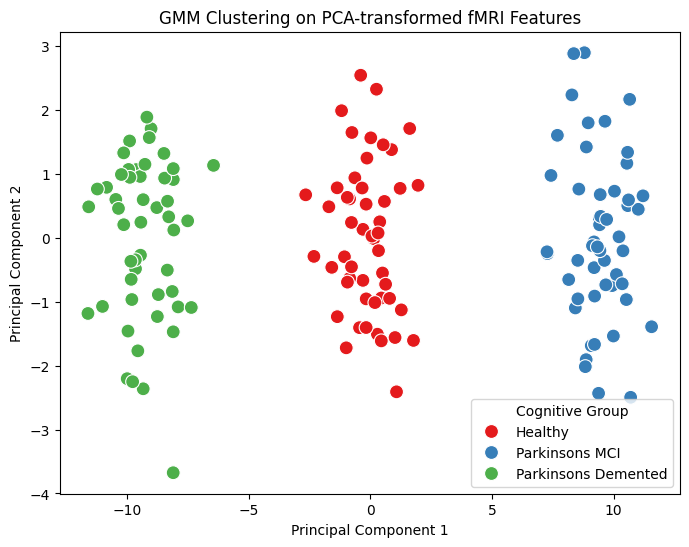

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Simulate Sample Data
# -------------------------------
# For demonstration, simulate fMRI features (e.g., fALFF and CV for DMN regions)
np.random.seed(42)
n_patients = 150

# Simulate data for three clusters corresponding to healthy, MCI, and demented groups
data_cluster1 = np.random.normal(loc=0, scale=1, size=(50, 10))
data_cluster2 = np.random.normal(loc=3, scale=1, size=(50, 10))
data_cluster3 = np.random.normal(loc=-3, scale=1, size=(50, 10))
data = np.vstack([data_cluster1, data_cluster2, data_cluster3])
df_features = pd.DataFrame(data, columns=[f'feature_{i}' for i in range(10)])

# Simulate a cognitive composite score (e.g., global score) where we expect:
#   - Higher scores for healthy, intermediate for MCI, and lower for demented.
cognitive_scores = np.concatenate([
    np.random.normal(loc=1, scale=0.5, size=50),   # Healthy
    np.random.normal(loc=0, scale=0.5, size=50),   # MCI
    np.random.normal(loc=-1, scale=0.5, size=50)   # Demented
])
df_features['global'] = cognitive_scores

# -------------------------------
# 2. Dimensionality Reduction with PCA
# -------------------------------
# Here we cluster based on the fMRI features.
X = df_features.drop(columns=['global']).values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# -------------------------------
# 3. Clustering using Gaussian Mixture Model (GMM)
# -------------------------------
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
clusters = gmm.fit_predict(X_pca)
df_features['cluster'] = clusters

# Evaluate the clustering using the silhouette score
sil_score = silhouette_score(X_pca, clusters)
print("Silhouette Score (GMM on PCA data):", sil_score)

# -------------------------------
# 4. Mapping Clusters to Clinical Groups
# -------------------------------
# Assume that the mean global cognitive score in each cluster is indicative:
#   - Highest mean → Healthy
#   - Middle mean   → Parkinson's MCI
#   - Lowest mean   → Parkinson's Demented
cluster_means = df_features.groupby('cluster')['global'].mean().sort_values(ascending=False)
print("\nCluster Mean Global Scores:\n", cluster_means)

# Map clusters based on sorted global scores
label_mapping = {}
labels_order = ['Healthy', 'Parkinsons MCI', 'Parkinsons Demented']
for new_label, (cluster, mean_val) in zip(labels_order, cluster_means.items()):
    label_mapping[cluster] = new_label

df_features['cognitive_group'] = df_features['cluster'].map(label_mapping)
print("\nSample Data with Assigned Groups:")
print(df_features.head())

# -------------------------------
# 5. Visualization
# -------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=df_features['cognitive_group'], palette='Set1', s=100)
plt.title("GMM Clustering on PCA-transformed fMRI Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cognitive Group")
plt.show()
